# Random Effects Neural Networks with Edward and Keras

# models to build

- linear model
- linear mixed effects model
- linear hierarchical model
- linear mixed effects hierarchical model with neural network

# notes
- plop in the neural net
- edward is awesome?
- we're super flexible in all directions with edward, keras

# things to do
- make this work for train and validation sets of unequal size

The goal of this post is to plant the seed -- to show how we can easily branch out in all directions.

In [1]:
import edward as ed
from edward.models import Normal
from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [ ]:
sess = ed.get_session()
K.set_session(sess)

INIT_OP = tf.global_variables_initializer()

## Data preparation

cite the kaggle EDA kernel.

In [2]:
properties_df = pd.read_csv('data/properties.csv', low_memory=False)
transactions_df = pd.read_csv('data/transactions.csv')

In [3]:
properties_df = properties_df.rename(columns={
    'parcelid': 'id_parcel',
    'yearbuilt': 'build_year',
    'basementsqft': 'area_basement',
    'yardbuildingsqft17': 'area_patio',
    'yardbuildingsqft26': 'area_shed',
    'poolsizesum': 'area_pool',
    'lotsizesquarefeet': 'area_lot',
    'garagetotalsqft': 'area_garage',
    'finishedfloor1squarefeet': 'area_firstfloor_finished',
    'calculatedfinishedsquarefeet': 'area_total_calc',
    'finishedsquarefeet6': 'area_base',
    'finishedsquarefeet12': 'area_live_finished',
    'finishedsquarefeet13': 'area_liveperi_finished',
    'finishedsquarefeet15': 'area_total_finished',
    'finishedsquarefeet50': 'area_unknown',
    'unitcnt': 'num_unit',
    'numberofstories': 'num_story',
    'roomcnt': 'num_room',
    'bathroomcnt': 'num_bathroom',
    'bedroomcnt': 'num_bedroom',
    'calculatedbathnbr': 'num_bathroom_calc',
    'fullbathcnt': 'num_bath',
    'threequarterbathnbr': 'num_75_bath',
    'fireplacecnt': 'num_fireplace',
    'poolcnt': 'num_pool',
    'garagecarcnt': 'num_garage',
    'regionidcounty': 'region_county',
    'regionidcity': 'region_city',
    'regionidzip': 'region_zip',
    'regionidneighborhood': 'region_neighbor',
    'taxvaluedollarcnt': 'tax_total',
    'structuretaxvaluedollarcnt': 'tax_building',
    'landtaxvaluedollarcnt': 'tax_land',
    'taxamount': 'tax_property',
    'assessmentyear': 'tax_year',
    'taxdelinquencyflag': 'tax_delinquency',
    'taxdelinquencyyear': 'tax_delinquency_year',
    'propertyzoningdesc': 'zoning_property',
    'propertylandusetypeid': 'zoning_landuse',
    'propertycountylandusecode': 'zoning_landuse_county',
    'fireplaceflag': 'flag_fireplace',
    'hashottuborspa': 'flag_tub',
    'buildingqualitytypeid': 'quality',
    'buildingclasstypeid': 'framing',
    'typeconstructiontypeid': 'material',
    'decktypeid': 'deck',
    'storytypeid': 'story',
    'heatingorsystemtypeid': 'heating',
    'airconditioningtypeid': 'aircon',
    'architecturalstyletypeid': 'architectural_style'
})

transactions_df = transactions_df.rename(columns={
  'parcelid': 'id_parcel',
  'transactiondate': 'date'
})

### Build training DataFrame

In [4]:
data = transactions_df.merge(properties_df, how='left', left_on='id_parcel', right_on='id_parcel')

### Drop columns containing too many nulls

In [5]:
keep_cols = data.columns[ data.isnull().mean() < .25 ]
data = data[keep_cols]

### Which columns are most correlated with the target?

In [6]:
float_cols = [col for col in data.columns if data[col].dtype == np.float64]

data[float_cols]\
    .corr()['logerror']\
    .abs()\
    .sort_values(ascending=False)\
    .head(10)

logerror               1.000000
area_live_finished     0.041922
area_total_calc        0.038784
num_bathroom_calc      0.029448
num_bath               0.028845
num_bathroom           0.027889
num_bedroom            0.025467
tax_building           0.022085
build_year             0.017312
censustractandblock    0.008892
Name: logerror, dtype: float64

### Select three fixed-effect predictors

In [7]:
fixed_effect_predictors = [
    'area_live_finished', 
    'num_bathroom', 
    'build_year'
]

### Select one random-effect predictor

In [57]:
zip_codes = data['region_zip'].astype('category').cat.codes

### Drop rows with null values
- make mention of the fact that you want to impute missing values

In [8]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

### Split data into train, validation sets

In [9]:
train_index = data.sample(frac=0.5).index
val_index = data.drop(train_index).index

X = data.drop('logerror', axis=1)[fixed_effect_predictors]
X = scale(X)
y = data['logerror'].values

X_train = X[train_index]
y_train = y[train_index]
X_val = X[val_index]
y_val = y[val_index]

print('Dataset sizes:')
print(f'    X_train:  {X_train.shape}')
print(f'    X_val:    {X_val.shape}')
print(f'    y_train:  {y_train.shape}')
print(f'    y_val:    {y_val.shape}')

Dataset sizes:
    X_train:  (36986, 3)
    X_val:    (36986, 3)
    y_train:  (36986,)
    y_val:    (36986,)


# Bayesian linear regression

### Fit model

In [10]:
N, D = X_train.shape

# fixed-effects placeholders
fixed_effects = tf.placeholder(tf.float32, [N, D])

# fixed-effects parameters
β_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
α = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# model
μ_y = α + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

# approximate fixed-effects distributions 
qβ_fixed_effects = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D])))
)
qα = Normal(
    loc=tf.Variable(tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)

In [11]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 4s | Loss: 34660.520


In [12]:
# something about what the softplus is, why we do the following, etc.

### Criticize model

In [50]:
def visualize_data_fit(X, y, β, α, title_prefix, n_samples=10):
    '''Plot lines generated via samples from parameter distributions of the first 
    two fixed effects, vs. observed data points.
    Args:
        X (np.array) : A design matrix of fixed effects.
        y (np.array) : A vector of responses.
        β (ed.RandomVariable) : A (presumably) multivariate distribution of fixed-effect parameters.
        α (ed.RandomVariable) : A univariate distribution of the model's intercept term.
        title_prefix (str) : A string to append to the beginning of the title.
        n_samples (int) : The number of lines to plot as drawn from the parameter distributions.
    '''
    
    # draw samples from parameter distributions
    β_samples = β.sample(n_samples).eval()
    α_samples = α.sample(n_samples).eval()
    
    # plot the first two dimensions of `X`, vs. `y`
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.title(f'{title_prefix} Parameter Samples vs. Observed Data')
    
    # plot lines defined by parameter samples
    inputs = np.linspace(-10, 10, num=500)
    for i in range(n_samples):
        output = inputs * β_samples[i][0] + inputs * β_samples[i][1] + α_samples[i][0]
        ax.plot(inputs, inputs, output)

#### Visualize data fit given parameter priors

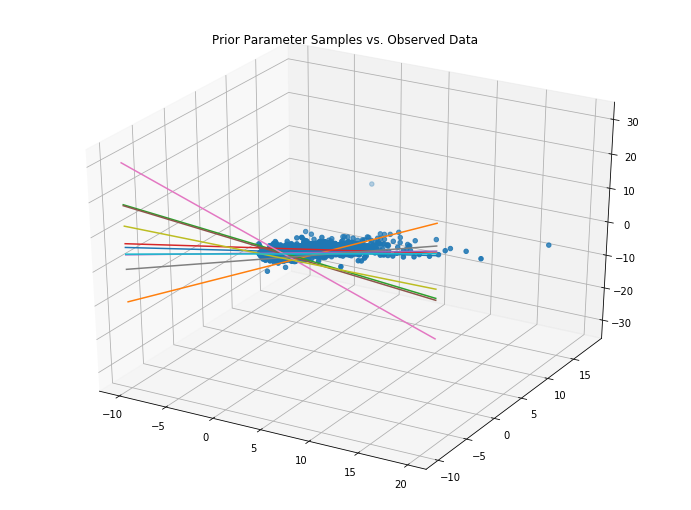

In [32]:
visualize_data_fit(X_train, y_train, β_fixed_effects, α, 'Prior', n_samples=10)

#### Visualize data fit given parameter posteriors

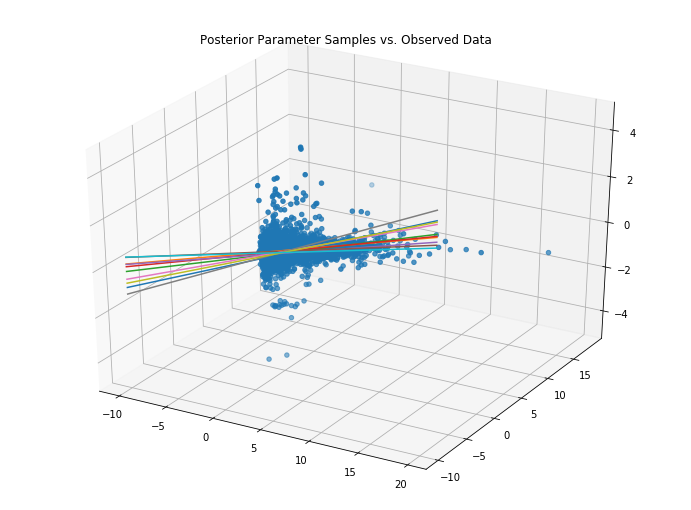

In [33]:
visualize_data_fit(X_train, y_train, qβ_fixed_effects, qα, 'Posterior', n_samples=10)

In [56]:
# note the axis scales as well!

# just because we fit the data doesn't mean we're fitting it well. this will become clearer when we compute the MAE.

#### Inspect residuals

In [48]:
def compute_mean_absolute_error(y_posterior, X_val_feed_dict, y_val=y_val):
    data = {y_posterior: y_val}
    data.update(X_val_feed_dict)
    mae = ed.evaluate('mean_absolute_error', data=data)
    print(f'Mean absolute error on validation data: {mae:1.5}')
    
def plot_residuals(y_posterior, X_val_feed_dict, title, y_val=y_val):
    y_posterior_preds = y_posterior.eval(feed_dict=X_val_feed_dict)
    plt.figure(figsize=(9, 6))
    plt.hist(y_posterior_preds - y_val, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    plt.title(title)

In [37]:
# if we omit the `.mean()` we still get point estimates for our posterior predictive. how do we get the full distribution?
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val
}
y_posterior = ed.copy(y, param_posteriors)

In [42]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.082094


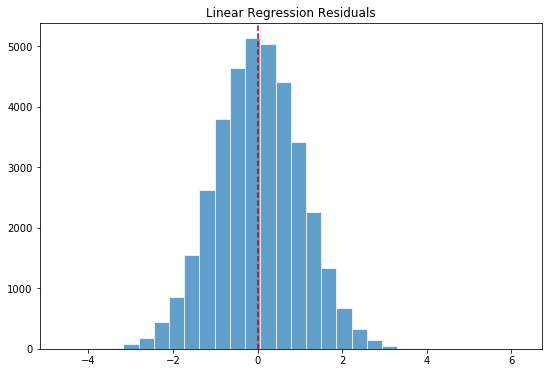

In [49]:
plot_residuals(y_posterior, X_val_feed_dict, title='Linear Regression Residuals')

#### Inspect parameter posteriors

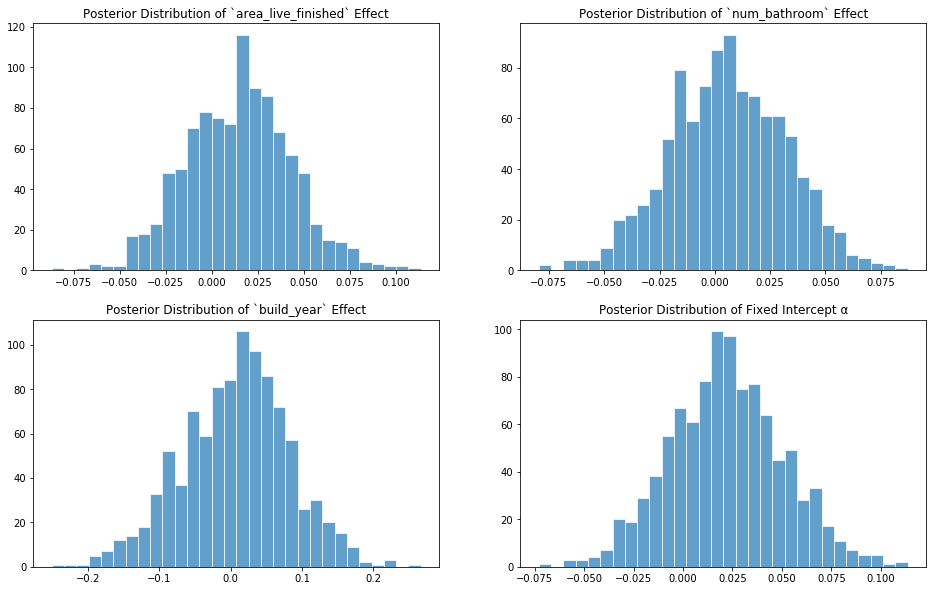

In [52]:
# draw samples from posteriors
qβ_fixed_effects_samples = qβ_fixed_effects.sample(1000).eval()
qα_samples = qα.sample(1000).eval()

# plot samples
plt.figure(figsize=(16, 10))

for dimension in range(D):
    subplot = plt.subplot(221 + dimension)
    plt.hist(qβ_fixed_effects_samples[:, dimension], edgecolor='white', linewidth=1, bins=30, alpha=.7)
    title = f'Posterior Distribution of `{fixed_effect_predictors[dimension]}` Effect'
    plt.title(title)
    
subplot = plt.subplot(221 + dimension + 1)
plt.hist(qα_samples, edgecolor='white', linewidth=1, bins=30, alpha=.7)
title = f'Posterior Distribution of Fixed Intercept α'
plt.title(title)

In [ ]:
# "conditional on the assumptions that the log error and other variables can be related by a straight line..."
# "multivariate regression model allows us to the answer the question: “what the is the predictive value of one variable once I already know the values of all other variables?”"
# - once I know A, what additional value is there in knowing B?
# - once I know B, what additional value is there in knowing A?
# the addition can be interpreted as an “or:”  μ  is a function of  x1  or  x2 
# the “or” indicates independent associations, which may be statistical or rather causal

## Bayesian linear regression with random effects

### Fit model

In [61]:
n_zip_codes = len(set(zip_codes))

# random-effect placeholder
zip_codes_ph = tf.placeholder(tf.int32, [None])

# random-effect parameter
σ_zip_code = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
α_zip_code = Normal(loc=tf.zeros(n_zip_codes), scale=σ_zip_code * tf.ones(n_zip_codes))

# β_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
# α = Normal(loc=tf.zeros(1), scale=tf.ones(1))
    
# model
random_effects = tf.gather(α_zip_code, zip_codes_ph)
μ_y = α + random_effects + ed.dot(fixed_effects, β_fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

# approximate random-effect distribution
qα_zip_code = Normal(
    loc=tf.Variable(tf.random_normal([n_zip_codes])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_zip_codes])))
)

In [70]:
latent_vars = {
    β_fixed_effects: qβ_fixed_effects,
    α: qα,
    α_zip_code: qα_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, zip_codes_ph: zip_codes[train_index], y: y_train})
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: 34535.785


### Criticize model

In [71]:
param_posteriors = {
    β_fixed_effects: qβ_fixed_effects.mean(),
    α: qα.mean(),
    α_zip_code: qα_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [74]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

Mean absolute error on validation data: 0.080423


#### Inspect residuals

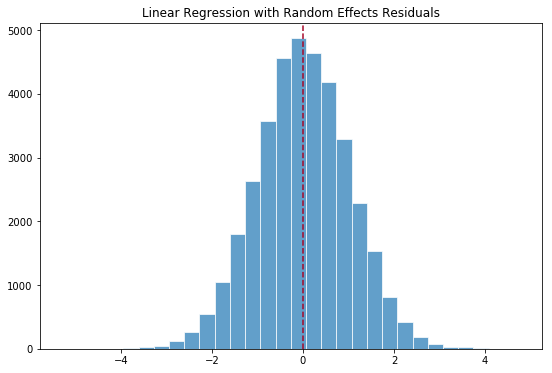

In [75]:
plot_residuals(y_posterior, X_val_feed_dict, title='Linear Regression with Random Effects Residuals')

#### Inspect shrinkage

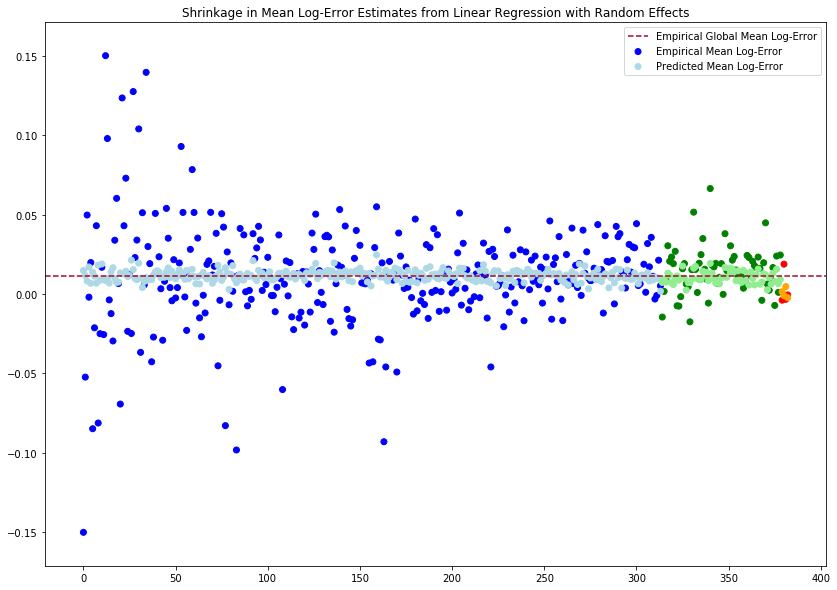

In [88]:
# retrodict μ_y of training data given inferred posterior parameter distributions
μ_y_posterior = ed.copy(μ_y, param_posteriors)
μ_y_posterior_preds = μ_y_posterior.eval( {fixed_effects: X_train, zip_codes_ph: zip_codes[train_index]} )

# group by zipcode, compute empirical mean `logerror` in training data
zip_codes_df = pd.DataFrame(
    data={'logerror': y_train, 'predicted_mean_logerror': μ_y_posterior_preds}, 
    index=zip_codes[train_index]
)
zip_codes_df = zip_codes_df\
    .groupby(level=0)\
    .mean()\
    .clip(-.15, .15)

# join observation counts of each distinct zipcode
zip_code_obs_counts = pd.Series(zip_codes[train_index].value_counts(), name='obs_count')
zip_codes_df = zip_codes_df.join(zip_code_obs_counts)

# cut counts into three buckets based on size
zip_codes_df['n_obs_color'] = pd.cut(zip_codes_df['obs_count'], bins=3, labels=['blue', 'green', 'red'])
zip_codes_df['n_obs_color_light'] = zip_codes_df['n_obs_color'].map({'blue': 'lightblue', 'green': 'lightgreen', 'red': 'orange'})

zip_codes_df = zip_codes_df\
    .sort_values(by='obs_count')\
    .reset_index(drop=True)
    
# plot shrinkage
plt.figure(figsize=(14, 10))
average_logerror = zip_codes_df['logerror'].mean()

plt.scatter(zip_codes_df.index, zip_codes_df['logerror'], c=zip_codes_df['n_obs_color'], label='Empirical Mean Log-Error')
plt.scatter(zip_codes_df.index, zip_codes_df['predicted_mean_logerror'], c=zip_codes_df['n_obs_color_light'], label='Predicted Mean Log-Error')
plt.axhline(average_logerror, color='#A60628', linestyle='--', label='Empirical Global Mean Log-Error')
plt.title('Shrinkage in Mean Log-Error Estimates from Linear Regression with Random Effects')
plt.legend()

# chuck in a neural net

In [ ]:
# ensure you have the environment variable set

In [ ]:
sess = ed.get_session()
tf.global_variables_initializer().run()

In [ ]:
def neural_network(fixed_effects, λ=.001, input_dim=D):
    # docstring about how this requires whatever it requires, with link to keras blog post
    dense = Dense(5, activation='tanh', kernel_regularizer=l2(λ))(fixed_effects)
    output = Dense(1, activation='linear', name='output', kernel_regularizer=l2(λ))(dense)
    return K.squeeze(output, axis=1)

In [ ]:
# maybe a note here about if this is the right way to go about things
sess = ed.get_session()

from keras import backend as K
K.set_session(sess)

init_op = tf.global_variables_initializer()
sess.run(init_op)

In [ ]:
zip_codes = data['region_zip'].astype('category').cat.codes
n_zip_codes = len(set(zip_codes))

In [ ]:
zip_codes_ph = tf.placeholder(tf.int32, [None])


σ_zip_code = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
α_zip_code = Normal(loc=tf.zeros(n_zip_codes), scale=σ_zip_code * tf.ones(n_zip_codes))

random_effects = tf.gather(α_zip_code, zip_codes_ph)
μ_y = α + random_effects + neural_network(fixed_effects)
y = Normal(loc=μ_y, scale=tf.ones(N))

In [ ]:
qα_zip_code = Normal(
    loc=tf.Variable(tf.random_normal([n_zip_codes])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_zip_codes])))
)

In [ ]:
latent_vars = {
    α: qα,
    α_zip_code: qα_zip_code,
}

inference = ed.KLqp(latent_vars, data={fixed_effects: X_train})
optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)
inference.run(n_samples=5, n_iter=250)

In [ ]:
param_posteriors = {
    α: qα.mean(),
    α_zip_code: qα_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [ ]:
y_posterior_preds = y_posterior.eval(feed_dict=X_val_feed_dict)

In [ ]:
compute_mean_absolute_error(y_posterior, X_val_feed_dict)

In [ ]:
plot_residuals(y_posterior, X_val_feed_dict, title='Random Effects Neural Network Residuals')

# future work

- varying slopes models
    - we probably need tensorflow for this?
    - covariance matrices
- we could have a random effect on each bias term for each layer
- flexibilities all around
- pymc does missing value imputation it seems

# references
- http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/
- https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html
- http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html